# Quantum entanglement and quantum teleportation

<img src="https://imgs.xkcd.com/comics/quantum_teleportation.png"/>

<div align="right">(Image credit: <a href=https://xkcd.com/465/>xkcd.com</a>)</div>

This demo notebook shows what quantum entanglement is about, and how we can exploit it to teleport qubits between quantum systems, even at infinite physical distance!

## Configuration

We first do the necessary imports

In [1]:
from collections import Counter
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit_textbook.tools import array_to_latex
from qiskit.visualization import plot_histogram

## Quantum entanglement

Entanglement is a property of quantum systems that does not exist in classical systems. Entanglement of 2 or more qubits implies that **measuring a subset of the qubits also modifies the state of the other qubits**. The most simple case of entanglement can be obtain as the so called **Bell pair**, which takes the form

$
|\beta\rangle = \left( \begin{matrix}\frac{1}{\sqrt{2}}\\0\\0\\\frac{1}{\sqrt{2}}\end{matrix} \right)
$

This state vector means we will have the same probability of obtaining the bits $00$ and $11$ when measuring the circuit, but no probability of measuring $01$ or $10$.

How is this state obtained? This is a complex state that cannot be expressed as a tensor product of basic states. However, it can be obtained applying a **Hadamard** gate on the first qubit, and then a **NOT** on the second bit **conditioned** on the first one:

$H |0\rangle = \frac{1}{\sqrt{2}} \left( \begin{matrix} 1&1\\1&-1\\ \end{matrix} \right) \left( \begin{matrix}1\\0\end{matrix} \right)
 = \left( \begin{matrix}  \frac{1}{\sqrt{2}} \\  \frac{1}{\sqrt{2}} \end{matrix} \right)
 = \frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle = |+\rangle
 $

$CNOT (|+\rangle \otimes |0\rangle )
= CNOT \left( \left( \frac{1}{\sqrt{2}} |0\rangle + \frac{1}{\sqrt{2}} |1\rangle \right) \otimes |0\rangle \right)
= CNOT \left( \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |10\rangle \right)
= \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}} |11\rangle
= |\beta\rangle
$

The following function creates a Bell pair between the qubits $a$ and $b$ in the given quantum circuit.

In [2]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

The circuit looks as follows

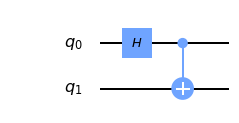

In [3]:
bell_circuit = QuantumCircuit(2)
create_bell_pair(bell_circuit, 0, 1)
bell_circuit.draw(output='mpl')

We can run the circuit in the **State vector simulator** to make sure we have indeed obtained the desired state. This simulator runs on our local (classical) computer and, for a small number of qubits, can return the state of the quantum system at the end of the circuit.

In [4]:
backend = BasicAer.get_backend('statevector_simulator')
state = execute(bell_circuit, backend).result().get_statevector()
array_to_latex(state, pretext="|\\beta\\rangle =")

<IPython.core.display.Math object>

Good! Now recall that this state vector means we will have the same probability of obtaining the bits $00$ and $11$ when measuring the circuit, but no probability of measuring $01$ or $10$. We can check this is true by adding measurement gates at the end of our circuit and running it in the **QASM simulator**. This simulator emulates an execution of the quantum circuit, returning the classical bits obtained in the measurements. We will run the simulator 1024 times to analyze the distribution of measurements.

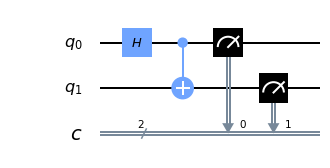

In [5]:
qc = QuantumCircuit(2, 2)
qc += bell_circuit
qc.measure(0,0)
qc.measure(1,1)
qc.draw(output='mpl')

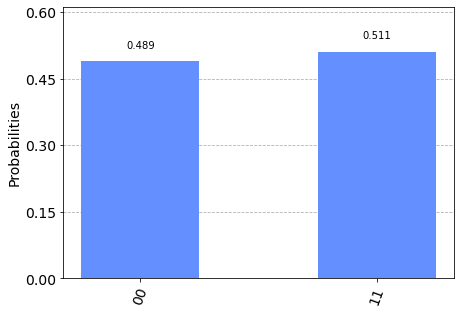

In [6]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

The probabilities of outputs $00$ and $11$ are roughly the same, while we never found states $01$ or $10$ in the result.

But why does this Bell pair has the entanglement propery? The interesting effect here is that **measuring just one of the qubits also modifies the state of the other qubit**. This can be tested creating a circuit that measures just one of the qubits.

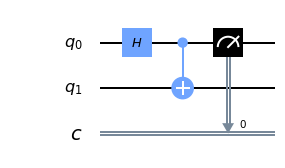

In [7]:
qc = QuantumCircuit(2, 1)
qc += bell_circuit
qc.measure(0,0)
qc.draw(output='mpl')

To understand this effect, first we first need to rewrite the Bell state as a linear combination of basic states, as we did in the derivation above

$
|\beta\rangle = \left( \begin{matrix}\frac{1}{\sqrt{2}}\\0\\0\\\frac{1}{\sqrt{2}}\end{matrix} \right)
= \left( \begin{matrix}\frac{1}{\sqrt{2}}\\0\\0\\0\end{matrix} \right)
+ \left( \begin{matrix}0\\0\\0\\\frac{1}{\sqrt{2}}\end{matrix} \right) 
= \frac{1}{\sqrt{2}} |00\rangle + \frac{1}{\sqrt{2}}|11\rangle
$

Now consider the following possible scenarios when measuring the first qubit, $q_0$:

* $q_0$ is measured as $0$. This means the first qubit has collapsed to state $|0\rangle$. But then, from the two possible joint states $|00\rangle$ and $|11\rangle$ the only one with $q_0 = |0\rangle$ is $|00\rangle$, which means $q_1$ can now only take the value $|0\rangle$!
* $q_0$ is measured as $1$. This means the first qubit has collapsed to state $|1\rangle$. But then, from the two possible joint states $|00\rangle$ and $|11\rangle$ the only one with $q_0 = |1\rangle$ is $|11\rangle$, which means $q_1$ can now only take the value $|1\rangle$!

The same holds true if we instead measure $q_1$ and analyze the possible states of $q_0$. Therefore, measuring one qubit means the other one automatically collapses to the same state vector!

Not conviced enough? Let's try it in the simulator! We will do 128 runs of the circuit above, and note down what  is the measured bit for $q_0$, together with the quantum state of the whole system

In [24]:
backend = BasicAer.get_backend('statevector_simulator')
measurements = []
state_vectors = []
for i in range(128):
    result = execute(qc, backend).result()
    measured_value = list(result.get_counts().keys())[0]
    measurements.append(measured_value)
    state_vector = result.get_statevector().tolist()
    state_vectors.append(state_vector)
    print(f"Classical bit measured is {measured_value}, quantum system state is {state_vector}")
    
counts = Counter([
    f"{measured_value}, {state_vector}" 
    for measured_value, state_vector in zip(measurements, state_vectors)
])
print(f"Counts on combined states: {counts}")

Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 0, quantum system state is [(1+0j), 0j, 0j, 0j]
Classical bit measured is 1, quantum s

Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Classical bit measured is 1, quantum system state is [0j, 0j, 0j, (1+0j)]
Counts on combined states: Counter({'0, [(1+0j), 0j, 0j, 0j]': 77, '1, [0j, 0j, 0j, (1+0j)]': 51})


As we can see, every time we measure a $0$ in $q_0$ the system collapses to state $|00\rangle$, and every time we measure a $1$ in $q_0$ the system collapses to state $|11\rangle$. In classical computing this would mean that **just reading** a variable can change the value of another variable. In the physical world it means that **just measuring** a property of an element in a quantum system can change the property of a different element, **even if they are physically apart**. This is the so called **spooky action at a distance** that seemed impossible in classical physics, and will be the key property of Quantum Teleportation.

## Quantum Teleportation

Now that we have seen the effect of quantum entanglement, we will learn how it can be used to teleport a qubit from one location to other.

### Preparing resources

Suppose **Alice** wants to secretly send a qubit $|q\rangle = a |0\rangle + b |1\rangle$ to her friend **Bob**. A qubit cannot be sent through classic communication channels, but we can **teleport** such qubit to Bob. How? We would require a third-party to prepare a couple of qubits $|\psi\rangle = |\psi_A \psi_B\rangle$ entangled in a Bell state, and to distribute $|\psi_A \rangle$ to Alice, $|\psi_B \rangle$ to Bob. We can prepare this setting in the simulator as follows:

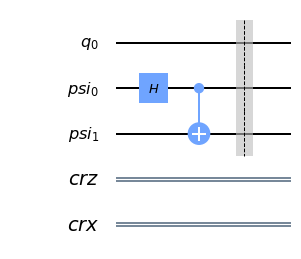

In [9]:
crz, crx = ClassicalRegister(1, "crz"), ClassicalRegister(1, "crx")
teleportation_circuit = QuantumCircuit(
    QuantumRegister(1, "q"),  # Alice qubit
    QuantumRegister(2, "psi"),  # Entangled pair
    crz, # Classical channel
    crx,  # Classical channel
)
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

In this circuit we are simulating that Alice owns the first two qubits at the top, her own qubit $|q\rangle$ and the first element of entangled qubit $|\psi_A\rangle$, while Bob owns the one at the bottom, which is the other half of the entangled pair, $|\psi_B\rangle$.

### Alice steps

For this notebook we will try teleporting simple qubit states, either $|0\rangle$ or $|1\rangle$, so that Alice can send binary messages. Note however that the protocol allows sendind any arbitrary qubit value.

We will start by creating a function that encodes the $|0\rangle$ or $|1\rangle$ values on the circuit. Since by default all qubits are initialized at $|0\rangle$, we just need to add an X gate (NOT gate) if we want to encode a $|1\rangle$.

In [10]:
def alice_encode(qc, q, value):
    if value == 1:
        qc.x(q)

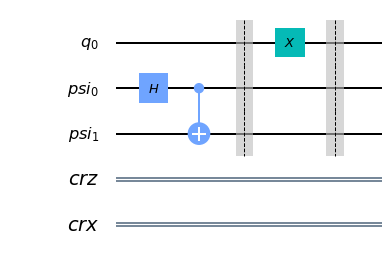

In [11]:
alice_encode(teleportation_circuit, 0, value=1)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

Now, to teleport her qubit Alice needs to apply a CNOT gate on $|\psi_A\rangle$ conditioned by $|q\rangle$, followed by a Hadamard gate on $|q\rangle$. This step entangles her qubit $|q\rangle$ with the already entangled couple $|\psi\rangle$.

In [12]:
def alice_gates(qc, q, psi):
    qc.cx(q, psi)
    qc.h(q)

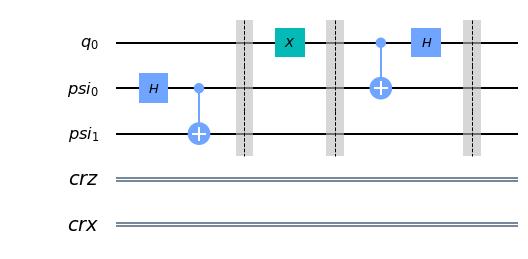

In [13]:
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

But, what is the effect of these operations? We will need to do the math step by step.

The state of 3-qubit system before the gates Alice applied can be described as

$|q\rangle \otimes |\psi\rangle = (a |0\rangle + b |1\rangle) \otimes \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle) = \frac{1}{\sqrt{2}} (a |000\rangle + a |011\rangle + b |100\rangle + b |111\rangle)$.

Now be apply a CNOT gate on $|\psi_A\rangle$ conditioned by $|q\rangle$, which means that for every basis vector the second qubit flips if the first is valued $1$:

$(CNOT \otimes I) (|q\rangle \otimes |\psi\rangle) = \frac{1}{\sqrt{2}} (a |000\rangle + a |011\rangle + b |110\rangle + b |101\rangle)$

The second gate that Alice applies is a Hadamard over $|q\rangle$. Recall that $H |0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$, $H |1\rangle = \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle)$, so we get

$|v\rangle = (H \otimes I \otimes I) \frac{1}{\sqrt{2}} (a |000\rangle + a |011\rangle + b |110\rangle + b |101\rangle)$

$= \frac{1}{2} \left( a (|000\rangle + |100\rangle) + a (|011\rangle + |111\rangle) + b (|010\rangle - |110\rangle) + b (|001\rangle - |101\rangle) \right)$

We can reorganize this expression by grouping terms around the possible values of the first two qubits,

$|v\rangle = \frac{1}{2} (|00\rangle \otimes (a |0\rangle + b |1\rangle) + |01\rangle \otimes ( a |1\rangle + b |0\rangle) + |10\rangle \otimes ( a |0\rangle - b |1\rangle) + |11\rangle \otimes (a |1\rangle - b |0\rangle)
$.

We can see that obtained state $|v\rangle $ is a tensor product of each one of the 2-qubit basis vectors ($|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$) together with different ways of combining the basis vectors $|0\rangle$ and $|1\rangle$ in the third qubit, with weights $a$ and $b$. Note $a$ and $b$ are the values of the qubit $|q\rangle$ we wanted to transfer in the first place.

The next step involces Alice **measuring** the first two qubits. This will destroy the superposition state in $|q\rangle$ and $|\psi_A\rangle$, but will provide the information Bob needs to rebuild $|q\rangle$ at his end. 

Suppose Alice measures $00$. This means the superposition state $|q \psi_A\rangle$ has collapsed to $|00\rangle$. The probability of this happening is the sum of probabilities of the states $|000\rangle$ and $|001\rangle$, that is 

$p(|00\rangle) = p(|000\rangle) + p(|001\rangle) 
  = \left|\frac{1}{2} a \right|^2 + \left| \frac{1}{2} b \right|^2
  = \frac{1}{4} (|a|^2 + |b|^2)
  = \frac{1}{4},
$

since the norm of vector $(a, b)$ must be $1$, as the qubit $|q\rangle$ is a valid qubit.

In this case the remaining qubit collapses to $|\psi_B\rangle = a |0\rangle + b |1\rangle$, as this is the only term of $|v\rangle$ compatible with the first two qubits collapsing to $|00\rangle$.

The rest of possible measurements ($01$, $10$, $11$) also have a probability of $\frac{1}{4}$, and we can work out the following table of the resultant states for $|\psi_B\rangle$.

| Measurement | $|\psi_B\rangle$ |
| --- | --- |
| $00$ | $a |0\rangle + b |1\rangle$ |
| $01$ | $a |1\rangle + b |0\rangle$ |
| $10$ | $a |0\rangle - b |1\rangle$ |
| $11$ | $a |1\rangle - b |0\rangle$ |

So depending on the measurement obtained by Alice, the qubit $|\psi_B\rangle$ held by Bob will take a different value. Alice will need to send Bob her measured qubits to allow Bob reconstructing $|q\rangle$. So let's add those measure steps to the circuit already.

In [14]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.measure(a,0)
    qc.measure(b,1)

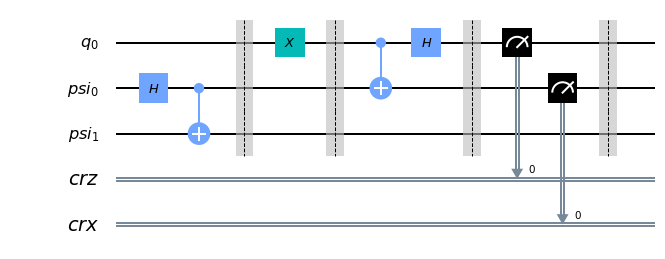

In [15]:
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

### Bob steps

Now Bob has received through a standard channel the two bits measured by Alice, and the qubit $|\psi_B\rangle$ he holds has also been modified at a distance through the operations and measurements of Alice on her end. 

If some third-party (Eve) would have been observing the communication protocol so far, she would only see a random string of binary numbers being sent from Alice to Bob. Therefore, it is impossible for Eve to capture the message. However, Bob holds the second element of the previously entangled qubit $|\psi\rangle$, and he nows with certainty the value of this qubit by indexing the table above with the two bits he got from Alice. So, to recover $|q\rangle$ he only needs to apply the appropriate transformations on $|\psi_B\rangle$. In particular:

| Measurement | $|\psi_B\rangle$ | Required operations |
| --- | --- | --- |
| $00$ | $a |0\rangle + b |1\rangle$ | I $|\psi_B\rangle$ |
| $01$ | $a |1\rangle + b |0\rangle$ | X $|\psi_B\rangle$ |
| $10$ | $a |0\rangle - b |1\rangle$ | Z $|\psi_B\rangle$ |
| $11$ | $a |1\rangle - b |0\rangle$ | Z X  $|\psi_B\rangle$ |

Recall the $X$ gate swaps $|0\rangle$ and $|1\rangle$, and that the $Z$ gate multiplies the amplitud of the $|1\rangle$ basis vector by $-1$. You can check that by applying the corresponding gates we always recover the state $a |0\rangle + b |1\rangle$.

So, let's add to the circuit those gates, conditioned on the classic bits Bob has received

In [16]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

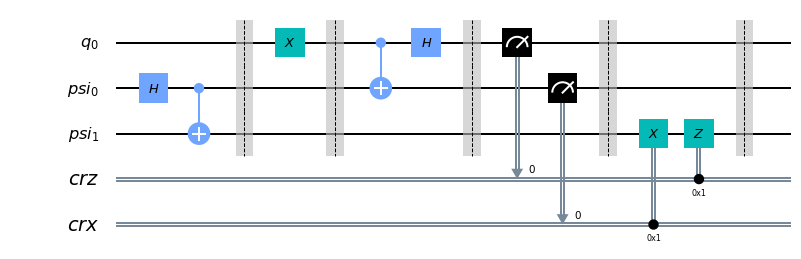

In [17]:
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

And with this, Bob now holds the original qubit $|q\rangle$!

### Full circuit

Here is a function comprising the whole teleportation circuit, configured to encode a given bit on Alice's side and take a measure of it on Bob's side

In [18]:
def build_teleportation_circuit(value):
    # Initialization
    crz, crx = ClassicalRegister(1, "crz"), ClassicalRegister(1, "crx")
    teleportation_circuit = QuantumCircuit(
        QuantumRegister(1, "q"),  # Alice qubit
        QuantumRegister(2, "psi"),  # Entangled pair
        crz, # Classical channel
        crx,  # Classical channel
        ClassicalRegister(1, "output")
    )
    create_bell_pair(teleportation_circuit, 1, 2)
    teleportation_circuit.barrier()
    
    # Alice encoding
    alice_encode(teleportation_circuit, 0, value=value)
    teleportation_circuit.barrier()
    
    # Alice gates
    alice_gates(teleportation_circuit, 0, 1)
    teleportation_circuit.barrier()
    
    # Alice measurements
    measure_and_send(teleportation_circuit, 0 ,1)
    teleportation_circuit.barrier()
    
    # Bob gates
    bob_gates(teleportation_circuit, 2, crz, crx)
    teleportation_circuit.barrier()
    
    # Bob measurement
    teleportation_circuit.measure(2, 2)
    
    return teleportation_circuit

We can test it in the simulator to teleport a bit valued $1$ through a qubit!

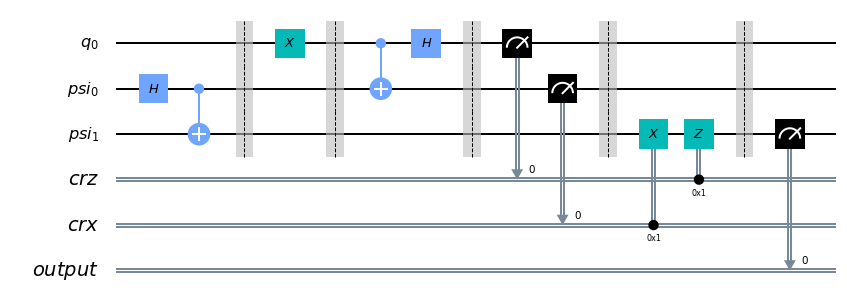

In [19]:
teleportation_circuit = build_teleportation_circuit(1)
teleportation_circuit.draw(output='mpl')

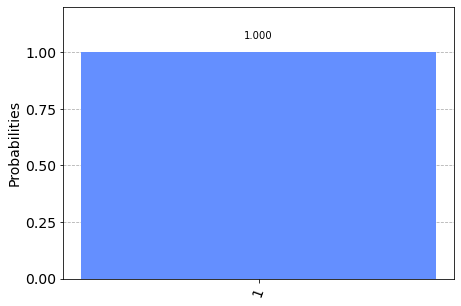

In [20]:
backend = BasicAer.get_backend('qasm_simulator')
result = execute(teleportation_circuit, backend, shots=1024).result()
counts = result.get_counts()
# Get from counts only the output bit of interest
counts = {x[0:1]: c for x, c in counts.items()}
plot_histogram(counts)

As we can see, in all simulations the transported qubit, once measured, returns $1$, so we have managed to teleport the quantum state $|1\rangle$ successfully!

Note that the qubit has been teleported from Alice to Bob, but now Alice does not have it anymore. Also, the Bell pair that was prepared for the transaction has become unentangled, so running this protocol implies losing entangled qubits.

## Sending a message through quantum teleportation

Finally, we will simulate sending a whole message, bit by bit, through quantum teleportation. Though such a thing can probably be done more efficiently, here we will build a new circuit for every bit to send. The following functions allow taking a string of text and transferring it through quantum teleporation bit by bit.

In [21]:
# string to bits and bits to string functions
# Reference: https://stackoverflow.com/questions/7396849/convert-binary-to-ascii-and-vice-versa

def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'


def send_quantum_message(message):
    received_bits = ""
    backend = BasicAer.get_backend('qasm_simulator')
    
    for bit in text_to_bits(message):
        qc = build_teleportation_circuit(int(bit))
        result = execute(qc, backend, shots=1).result()
        counts = result.get_counts()
        # Get from counts only the output bit of interest
        received_bit = list(counts.keys())[0][0]
        received_bits += received_bit
        
    return text_from_bits(received_bits)

In [22]:
message = "ola k ase, ase quantum o k ase"
received = send_quantum_message(message)
print(f"Sent message     : {message}")
print(f"Received message : {received}")

Sent message     : ola k ase, ase quantum o k ase
Received message : ola k ase, ase quantum o k ase


It worked! Hooray!

## Closing remarks

Note that all the quantum teleporations done in this notebook have been simulated. It is theoretically possible to run the same circuits in real quantum devices, though it would be very hard: we would need to distribute an entangled quantum pair to two different computers, without losing such entanglement due to interferences. This is something extremely difficult to do, though it has [already been accomplished by chinese scientist to send information to a satellite](https://www.space.com/37506-quantum-teleportation-record-shattered.html)! So, at some point in the future we might be able to use quantum teleporation for sending information securely.

Most of this notebook has been inspired by the [quantum teleporation notebook in the qiskit book](https://qiskit.org/textbook/ch-algorithms/teleportation.html). Kudos also to this [Microsoft lecture on quantum computing](https://youtu.be/F_Riqjdh2oM) and the [Coursera course on introduction to quantum computing](https://www.coursera.org/learn/quantum-computing-algorithms).